In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import plot_training_history

2023-12-11 18:06:27.108544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 18:06:27.108774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 18:06:27.152119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 18:06:27.282861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 18:06:29.499132: W tensorflow/compiler/tf2

In [7]:
# Load and preprocess CIFAR-10 data
(train_images_x, train_labels_y), (test_images_x, test_labels_y) = cifar10.load_data()
train_images = tf.keras.applications.vgg16.preprocess_input(train_images_x)
test_images = tf.keras.applications.vgg16.preprocess_input(test_images_x)
train_labels = to_categorical(train_labels_y)
test_labels = to_categorical(test_labels_y)

In [8]:
train_images.shape, train_images_x.shape

((50000, 32, 32, 3), (50000, 32, 32, 3))

# Inspect VGG16 base model
VGG16 with and without its fully connected layers

In [ ]:
vgg_base_model_with_top = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
# include_top includs classification layers

553467096/553467096 [==============================] - 32s 0us/step


In [ ]:
vgg_base_model_with_top.layers

In [ ]:
vgg_base_model_with_top.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
vgg_base_model.layers

In [ ]:
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

# VGG16 feature extraction

In [ ]:
# Load pre-trained VGG16 model without the top layer
def create_vgg_feature_extraction_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    # Freeze the base model
    base_model.trainable = False # base model (without classifier) is frozen

    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(10, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = create_vgg_feature_extraction_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 14719928 (56.15 MB)
Trainable params: 5240 (20.47 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
def show_images(images, labels, num_rows=2, num_cols=2, scale=2):
    """Display a grid of images with labels."""
    _, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*scale, num_rows*scale))
    axs = axs.flatten()
    for img, ax, label in zip(images, axs, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Label: ' + str(label))
    plt.show()

In [ ]:
subset_images = train_images_x[16:20]
subset_labels = train_labels_y[16:20]

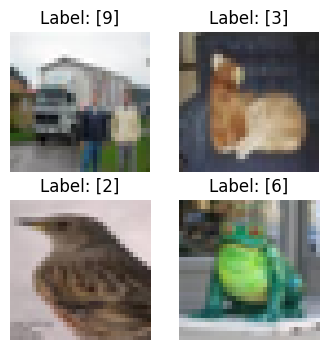

In [ ]:
show_images(subset_images, subset_labels)

# Evaluation of model

2023-12-11 15:39:39.212655: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/10
1250/1250 [==============================] - 362s 288ms/step - loss: 2.2099 - accuracy: 0.2150 - val_loss: 1.7846 - val_accuracy: 0.3286
Epoch 2/10
1250/1250 [==============================] - 394s 315ms/step - loss: 1.6328 - accuracy: 0.3949 - val_loss: 1.4820 - val_accuracy: 0.4474
Epoch 3/10
1250/1250 [==============================] - 371s 297ms/step - loss: 1.3539 - accuracy: 0.5044 - val_loss: 1.2692 - val_accuracy: 0.5456
Epoch 4/10
1250/1250 [==============================] - 368s 295ms/step - loss: 1.1880 - accuracy: 0.5770 - val_loss: 1.1684 - val_accuracy: 0.5910
Epoch 5/10
1250/1250 [==============================] - 366s 293ms/step - loss: 1.1324 - accuracy: 0.6015 - val_loss: 1.1524 - val_accuracy: 0.5963
Epoch 6/10
1250/1250 [==============================] - 424s 339ms/step - loss: 1.1124 - accuracy: 0.6089 - val_loss: 1.1353 - val_accuracy: 0.6034
Epoch 7/10
1250/1250 [==============================] - 384s 307ms/step - loss: 1.0996 - accuracy: 0.6129 - val_

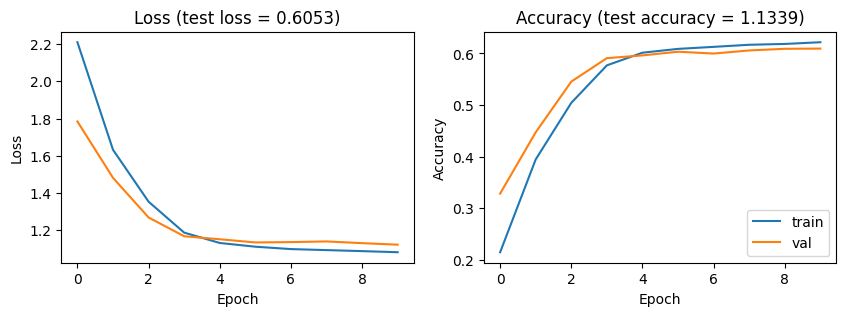

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

# Finetune VGG16

In [1]:
def create_vgg_finetuning_model():
    # Load pre-trained VGG16 model without the top layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Fine-tune from this layer onwards
    fine_tune_at = 11

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(10, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)

    # It's important to recompile the model after making any changes
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [4]:
model_finetune = create_vgg_finetuning_model()

In [5]:
model_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 14719928 (56.15 MB)
Trainable params: 12984440 (49.53 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


# Evaluate model


Epoch 1/5


2023-12-11 18:07:25.940000: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.


1250/1250 [==============================] - 2224s 2s/step - loss: 2.0792 - accuracy: 0.2767 - val_loss: 1.5758 - val_accuracy: 0.4488
Epoch 2/5
1250/1250 [==============================] - 2166s 2s/step - loss: 1.2573 - accuracy: 0.5756 - val_loss: 1.1067 - val_accuracy: 0.6485
Epoch 3/5
1250/1250 [==============================] - 1969s 2s/step - loss: 0.9117 - accuracy: 0.7214 - val_loss: 0.9162 - val_accuracy: 0.7336
Epoch 4/5
1250/1250 [==============================] - 2025s 2s/step - loss: 0.6915 - accuracy: 0.7947 - val_loss: 0.8140 - val_accuracy: 0.7689
Epoch 5/5
1250/1250 [==============================] - 2094s 2s/step - loss: 0.5249 - accuracy: 0.8399 - val_loss: 0.7592 - val_accuracy: 0.7854
313/313 - 68s - loss: 0.7932 - accuracy: 0.7759 - 68s/epoch - 216ms/step


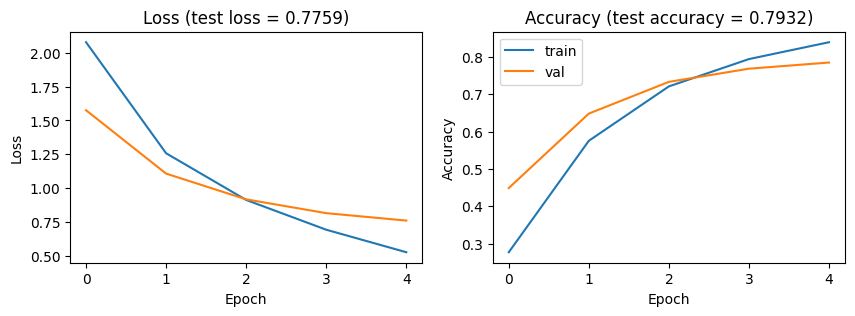

In [9]:
history = model_finetune.fit(train_images, train_labels, epochs=5, validation_split=0.2)
test_loss, test_accuracy = model_finetune.evaluate(test_images, test_labels, verbose=2)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

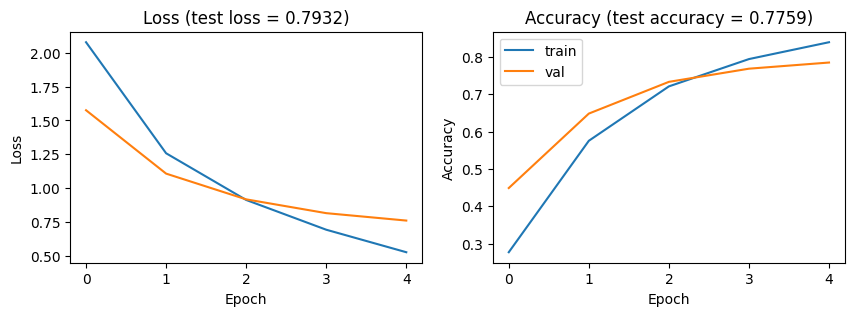

In [11]:
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)